# Import libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [8]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')

# Analisis
1. How well the borrower has performed in repayment on previous loans
2. Which occupancy group has no problem in repayment
3. The company's loss if it mistakenly determines potential borrowers who are difficult to pay

In [9]:
train.keys()

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [10]:
corr_rank = train.corr()['TARGET'].sort_values()

I looked at the corelation that were most highly and positively linked with the target variable.

In [11]:
corr_rank.head(n=15)

EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
ELEVATORS_MEDI               -0.033863
FLOORSMIN_AVG                -0.033614
FLOORSMIN_MEDI               -0.033394
LIVINGAREA_AVG               -0.032997
LIVINGAREA_MEDI              -0.032739
Name: TARGET, dtype: float64

In [12]:
corr_rank.tail(n=15)

DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

# Data Visualize

## Which gender is more dominant?

<AxesSubplot: xlabel='CODE_GENDER', ylabel='count'>

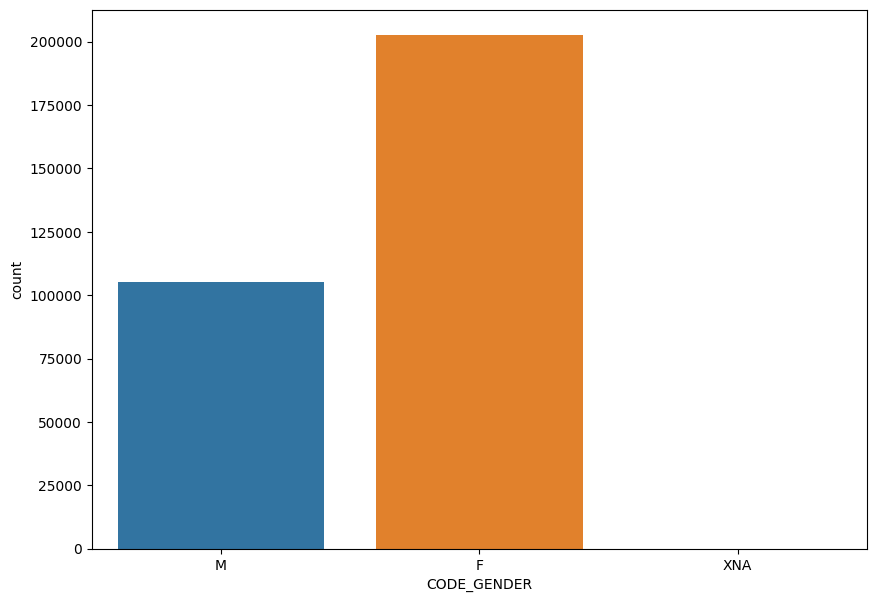

In [13]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='CODE_GENDER',data=train)

## How is the distribution of target labels? - Did most people return on time ?
0: Loan was repaid 1: Loan was not repaid

<AxesSubplot: xlabel='TARGET', ylabel='count'>

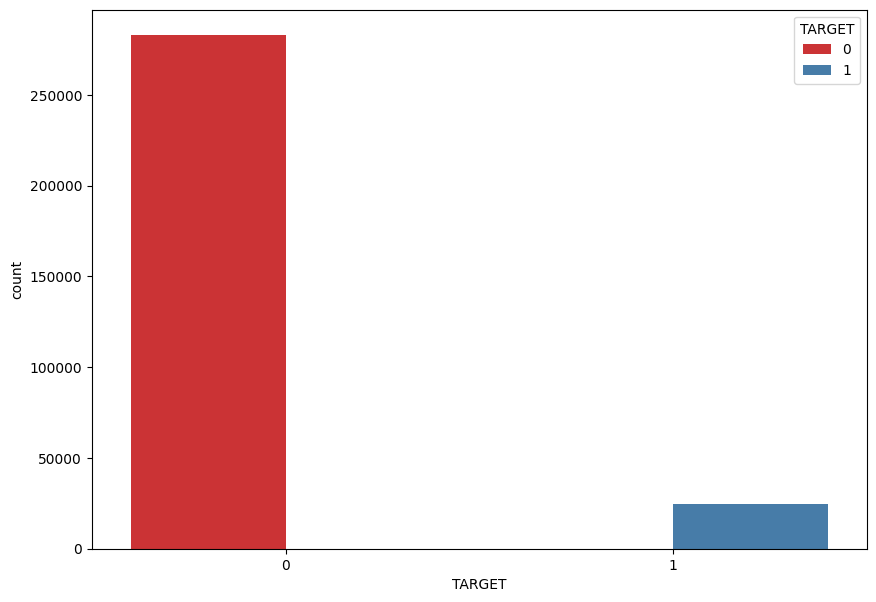

In [14]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x ='TARGET',data=train, hue='TARGET',palette="Set1")

## Who are the primary borrowers? What do they do?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Laborers'),
  Text(1, 0, 'Core staff'),
  Text(2, 0, 'Accountants'),
  Text(3, 0, 'Managers'),
  Text(4, 0, 'Drivers'),
  Text(5, 0, 'Sales staff'),
  Text(6, 0, 'Cleaning staff'),
  Text(7, 0, 'Cooking staff'),
  Text(8, 0, 'Private service staff'),
  Text(9, 0, 'Medicine staff'),
  Text(10, 0, 'Security staff'),
  Text(11, 0, 'High skill tech staff'),
  Text(12, 0, 'Waiters/barmen staff'),
  Text(13, 0, 'Low-skill Laborers'),
  Text(14, 0, 'Realty agents'),
  Text(15, 0, 'Secretaries'),
  Text(16, 0, 'IT staff'),
  Text(17, 0, 'HR staff')])

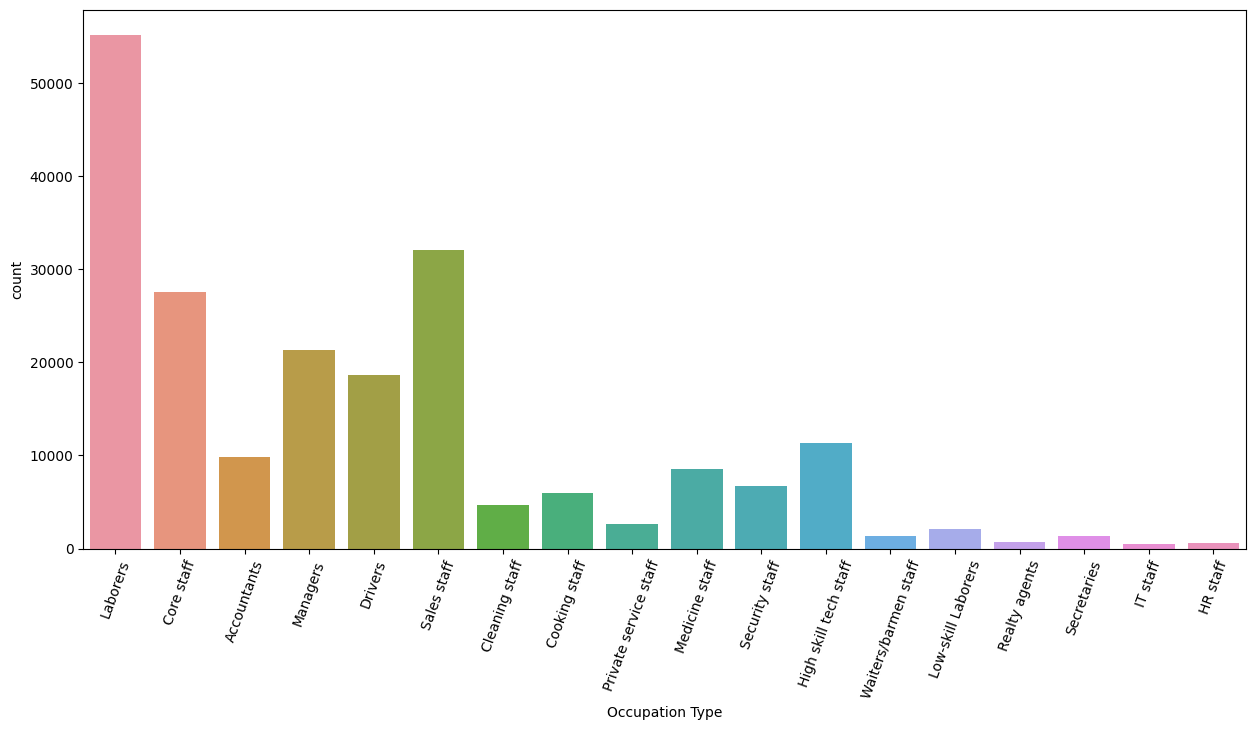

In [15]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x='OCCUPATION_TYPE',data=train)
plt.xlabel("Occupation Type")
plt.xticks(rotation=70)

## Which occupational category are better candidates for the business to lend money to because they pay back loans on time?

Text(0.5, 0, 'Occupation Type')

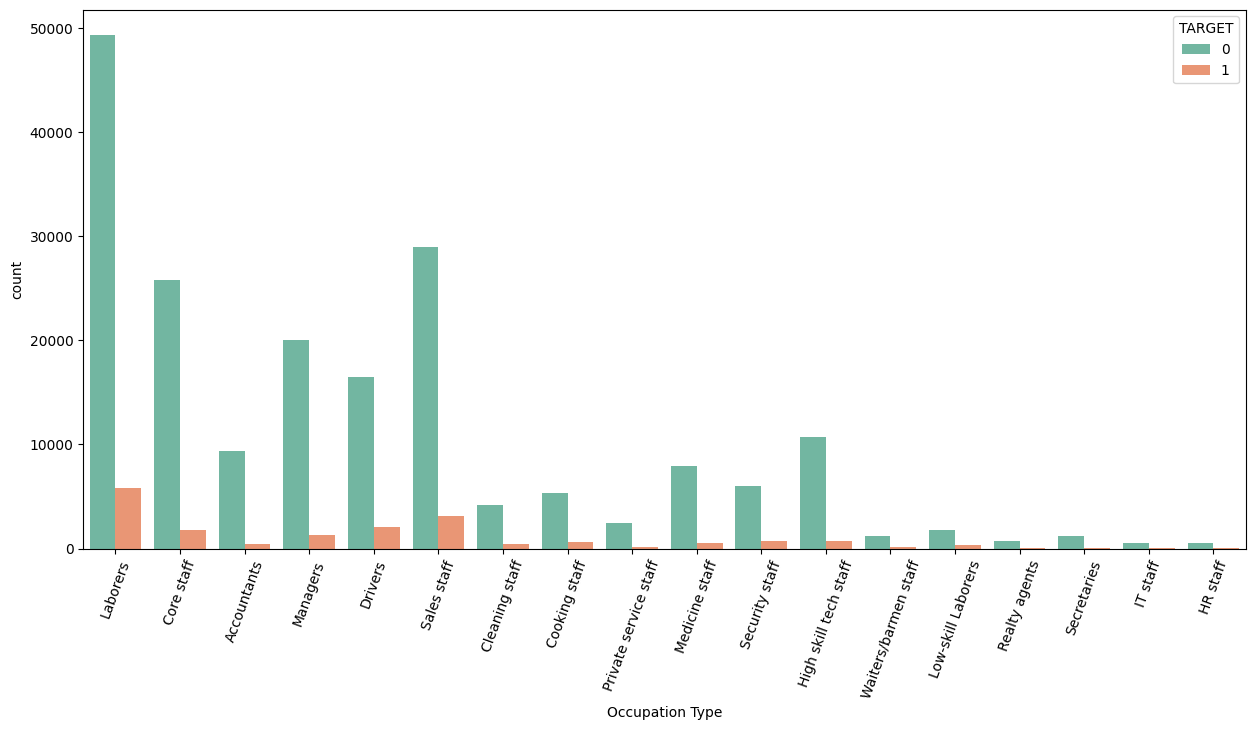

In [16]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x='OCCUPATION_TYPE',hue='TARGET',data=train,palette="Set2")
plt.xticks(rotation=70)
plt.xlabel("Occupation Type")

## Let's examine the proportion of payers to borrowers in each occupational category.

In [17]:
# get the number of people having occupation type and target grouped.
Occupation_df = pd.DataFrame(data=train.groupby(['OCCUPATION_TYPE','TARGET']).count()['SK_ID_CURR'])
Occupation_df

SK_ID_CURR
OCCUPATION_TYPE       TARGET            
Accountants           0             9339
                      1              474
Cleaning staff        0             4206
                      1              447
Cooking staff         0             5325
                      1              621
Core staff            0            25832
                      1             1738
Drivers               0            16496
                      1             2107
HR staff              0              527
                      1               36
High skill tech staff 0            10679
                      1              701
IT staff              0              492
                      1               34
Laborers              0            49348
                      1             5838
Low-skill Laborers    0             1734
                      1              359
Managers              0            20043
                      1             1328
Medicine staff        0             7965
                      1              572
Private service staff 0             2477
                      1              175
Realty agents         0              692
                      1               59
Sales staff           0            29010
                      1             3092
Secretaries           0             1213
                      1               92
Security staff        0             5999
                      1              722
Waiters/barmen staff  0             1196
                      1              152

In [18]:
# reset the multiindex organization of dataframe.
Occupation_df = Occupation_df.reset_index() 
Occupation_df

,OCCUPATION_TYPE,TARGET,SK_ID_CURR
0,Accountants,0,9339
1,Accountants,1,474
2,Cleaning staff,0,4206
3,Cleaning staff,1,447
4,Cooking staff,0,5325
5,Cooking staff,1,621
6,Core staff,0,25832
7,Core staff,1,1738
8,Drivers,0,16496
9,Drivers,1,2107


In [19]:
# get the number of people grouped on type of occupation and target in an array form.
value_counts = Occupation_df['SK_ID_CURR'].values
value_counts

array([ 9339,   474,  4206,   447,  5325,   621, 25832,  1738, 16496,
        2107,   527,    36, 10679,   701,   492,    34, 49348,  5838,
        1734,   359, 20043,  1328,  7965,   572,  2477,   175,   692,
          59, 29010,  3092,  1213,    92,  5999,   722,  1196,   152],
      dtype=int64)

In [20]:
def repayers_to_applicants_ratio(values):
    """
    Finds the ratio of Repayers to Applicants. This kind of is a 
    measure for safety. Larger the value better the applicant - More 
    safe for the company to lend loan to this category of workers.
    
    values: array of entires whose counts are given
    returns the repayers to applicants ratio. 
    
    precondition: The counts are such that the targets alligned are
    in order 0 and 1
    """
    flag = 1
    ratios = []
    for count in range(len(values)):
        if flag == 1:
            current_number = values[count]
            next_number = values[count+1]
            ratios.append(current_number/(current_number+next_number))
            ratios.append(current_number/(current_number+next_number))
        flag=flag*-1
    return ratios

In [21]:
# find the ratios from the array values
Occupation_df['Ratio R/A'] = repayers_to_applicants_ratio(value_counts)

In [22]:
# get the ratio and values based on the order of saftety.

Occupation_ratio_df = Occupation_df.groupby(['OCCUPATION_TYPE','Ratio R/A']).count().drop(['TARGET', 'SK_ID_CURR'],axis=1)
Occupation_ratio_df = Occupation_ratio_df.reset_index() 
Occupation_ratio_df = Occupation_ratio_df.sort_values(['Ratio R/A'],ascending=False)
Occupation_ratio_df

,OCCUPATION_TYPE,Ratio R/A
0,Accountants,0.951697
6,High skill tech staff,0.938401
10,Managers,0.937860
3,Core staff,0.936960
5,HR staff,0.936057
7,IT staff,0.935361
12,Private service staff,0.934012
11,Medicine staff,0.932998
15,Secretaries,0.929502
13,Realty agents,0.921438


Text(0, 0.5, 'Mean R/A Ratio')

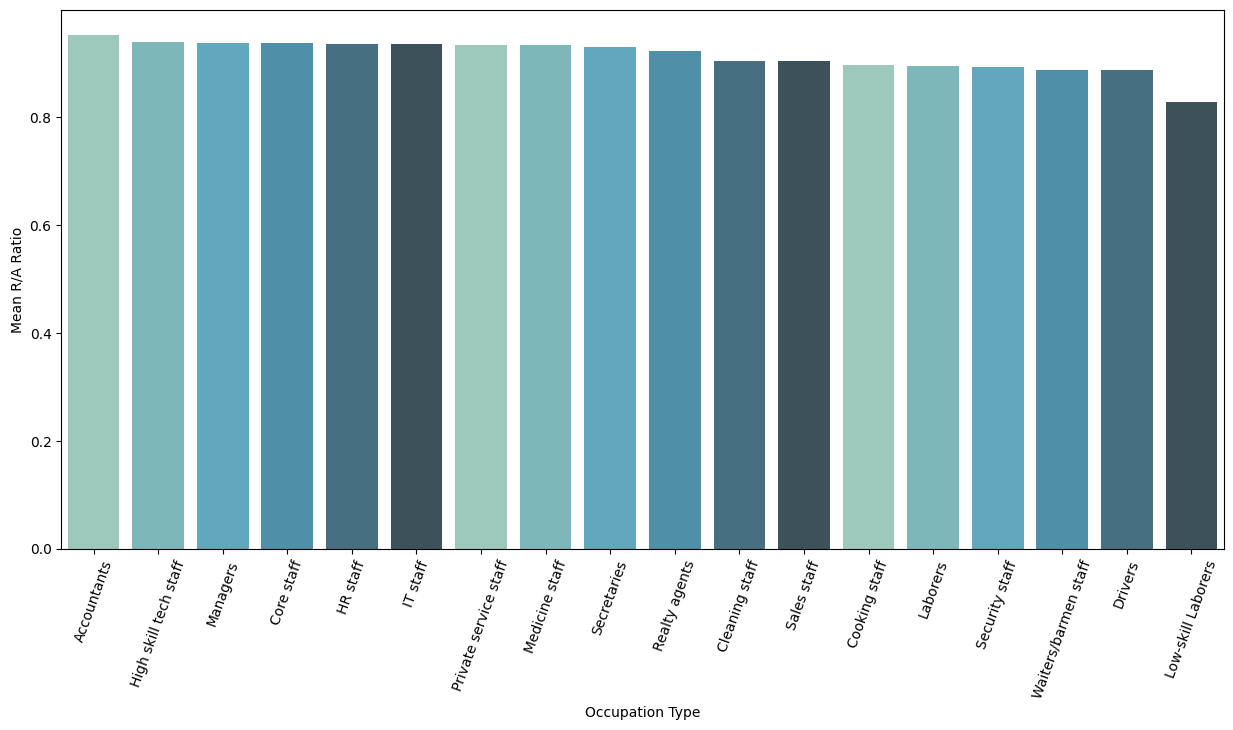

In [23]:
# Occupation type and occupation based repayment to applicants ratio.
fig,ax = plt.subplots(figsize = (15,7))
sns.barplot(x='OCCUPATION_TYPE',y='Ratio R/A',data=Occupation_ratio_df,palette=sns.color_palette("GnBu_d"))
plt.xticks(rotation=70)
plt.xlabel("Occupation Type")
plt.ylabel("Mean R/A Ratio")

# features Selection
* select the features that correlate the most. For now, I do it manually.

In [24]:
train = train[['TARGET', 'EXT_SOURCE_3', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'DEF_30_CNT_SOCIAL_CIRCLE']]

In [25]:
train

,TARGET,EXT_SOURCE_3,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_EMPLOYED,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DEF_30_CNT_SOCIAL_CIRCLE
0,1,0.139376,0.083037,0.262949,-637,-9461,2,2,-1134.0,-2120,2.0
1,0,NaN,0.311267,0.622246,-1188,-16765,1,1,-828.0,-291,0.0
2,0,0.729567,NaN,0.555912,-225,-19046,2,2,-815.0,-2531,0.0
3,0,NaN,NaN,0.650442,-3039,-19005,2,2,-617.0,-2437,0.0
4,0,NaN,NaN,0.322738,-3038,-19932,2,2,-1106.0,-3458,0.0
...,...,...,...,...,...,...,...,...,...,...,...
307506,0,NaN,0.145570,0.681632,-236,-9327,1,1,-273.0,-1982,0.0
307507,0,NaN,NaN,0.115992,365243,-20775,2,2,0.0,-4090,0.0
307508,0,0.218859,0.744026,0.535722,-7921,-14966,3,3,-1909.0,-5150,0.0
307509,1,0.661024,NaN,0.514163,-4786,-11961,2,2,-322.0,-931,0.0


In [26]:
test = test[['EXT_SOURCE_3', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'DEF_30_CNT_SOCIAL_CIRCLE']]

In [27]:
test

,EXT_SOURCE_3,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_EMPLOYED,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DEF_30_CNT_SOCIAL_CIRCLE
0,0.159520,0.752614,0.789654,-2329,-19241,2,2,-1740.0,-812,0.0
1,0.432962,0.564990,0.291656,-4469,-18064,2,2,0.0,-1623,0.0
2,0.610991,NaN,0.699787,-4458,-20038,2,2,-856.0,-3503,0.0
3,0.612704,0.525734,0.509677,-1866,-13976,2,2,-1805.0,-4208,0.0
4,NaN,0.202145,0.425687,-2191,-13040,2,2,-821.0,-4262,0.0
...,...,...,...,...,...,...,...,...,...,...
48739,0.643026,NaN,0.648575,-5169,-19970,3,3,-684.0,-3399,0.0
48740,NaN,NaN,0.684596,-1149,-11186,2,2,0.0,-3003,0.0
48741,0.283712,0.733503,0.632770,-3037,-15922,2,2,-838.0,-1504,0.0
48742,0.595456,0.373090,0.445701,-2731,-13968,2,2,-2308.0,-1364,0.0


# Handling Null

In [28]:
train['TRAINING'] = True
test['TRAINING'] = False

In [29]:
y = train.TARGET

In [30]:
y

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [31]:
train.drop(columns = 'TARGET', inplace=True)

In [32]:
x = pd.concat([train, test], axis = 0)

In [33]:
x.DAYS_EMPLOYED.describe()

count    356255.000000
mean      64317.231413
std      141705.532576
min      -17912.000000
25%       -2781.000000
50%       -1224.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [34]:
x['DAYS_EMPLOYED'] = x['DAYS_EMPLOYED'].apply(lambda x: np.nan if x == 365243 else x)

# Clean up

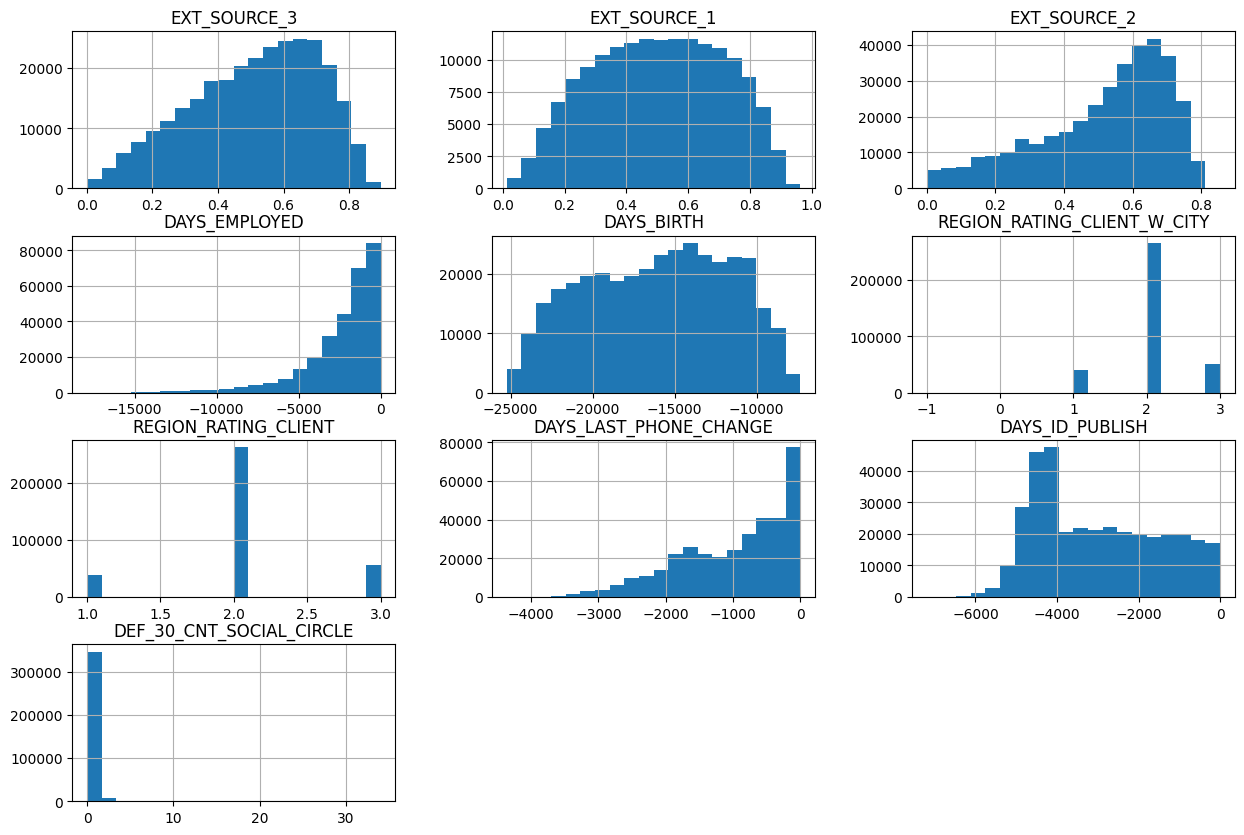

In [35]:
x.hist(figsize = (15,10), bins = 20);

In [36]:
x.nunique()

EXT_SOURCE_3                      814
EXT_SOURCE_1                   134315
EXT_SOURCE_2                   127157
DAYS_EMPLOYED                   12895
DAYS_BIRTH                      17467
REGION_RATING_CLIENT_W_CITY         4
REGION_RATING_CLIENT                3
DAYS_LAST_PHONE_CHANGE           3846
DAYS_ID_PUBLISH                  6224
DEF_30_CNT_SOCIAL_CIRCLE           10
TRAINING                            2
dtype: int64

# Transformations

In [37]:
skew_list = x.skew()

In [38]:
skew_list

EXT_SOURCE_3                  -0.398628
EXT_SOURCE_1                  -0.077242
EXT_SOURCE_2                  -0.793076
DAYS_EMPLOYED                 -1.954988
DAYS_BIRTH                    -0.115918
REGION_RATING_CLIENT_W_CITY    0.052475
REGION_RATING_CLIENT           0.081122
DAYS_LAST_PHONE_CHANGE        -0.711807
DAYS_ID_PUBLISH                0.338329
DEF_30_CNT_SOCIAL_CIRCLE       8.111785
TRAINING                      -2.113585
dtype: float64

# Scaling

In [39]:
cols_to_scale = x.select_dtypes(exclude = ['object', 'bool']).columns.values.tolist()
cols_to_scale

['EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_ID_PUBLISH',
 'DEF_30_CNT_SOCIAL_CIRCLE']

In [40]:
robust_scaler = RobustScaler().fit(x[cols_to_scale])
standard_scaler = StandardScaler().fit(x[cols_to_scale])
minmax_scaler = MinMaxScaler().fit(x[cols_to_scale])

In [41]:
x[cols_to_scale] = robust_scaler.transform(x[cols_to_scale])

In [42]:
x

,EXT_SOURCE_3,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_EMPLOYED,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DEF_30_CNT_SOCIAL_CIRCLE,TRAINING
0,-1.327464,-1.252419,-1.126607,0.423967,0.868018,0.0,0.0,-0.277948,0.435217,2.0,True
1,NaN,-0.576862,0.214188,0.196281,-0.139291,-1.0,-1.0,-0.043645,1.138408,0.0,True
2,0.660472,NaN,-0.033351,0.594215,-0.453868,0.0,0.0,-0.033691,0.277201,0.0,True
3,NaN,NaN,0.319407,-0.568595,-0.448214,0.0,0.0,0.117917,0.313341,0.0,True
4,NaN,NaN,-0.903489,-0.568182,-0.576058,0.0,0.0,-0.256508,-0.079200,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...
48739,0.368976,NaN,0.312441,-1.448760,-0.581299,1.0,1.0,0.066616,-0.056517,0.0,False
48740,NaN,NaN,0.446860,0.212397,0.630120,0.0,0.0,0.590352,0.095732,0.0,False
48741,-0.841298,0.672947,0.253460,-0.567769,-0.023031,0.0,0.0,-0.051302,0.672049,0.0,False
48742,0.208749,-0.393868,-0.444627,-0.441322,0.246449,0.0,0.0,-1.176876,0.725875,0.0,False


# Encoding

In [43]:
x = pd.get_dummies(x)

# Imputing Nulls

In [107]:
imputer = IterativeImputer()

In [46]:
x.isna().sum()

EXT_SOURCE_3                    69633
EXT_SOURCE_1                   193910
EXT_SOURCE_2                      668
DAYS_EMPLOYED                   64648
DAYS_BIRTH                          0
REGION_RATING_CLIENT_W_CITY         0
REGION_RATING_CLIENT                0
DAYS_LAST_PHONE_CHANGE              1
DAYS_ID_PUBLISH                     0
DEF_30_CNT_SOCIAL_CIRCLE         1050
TRAINING                            0
dtype: int64

In [47]:
x = pd.DataFrame(imputer.fit_transform(x), columns = x.columns)

In [48]:
x

,EXT_SOURCE_3,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_EMPLOYED,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DEF_30_CNT_SOCIAL_CIRCLE,TRAINING
0,-1.327464,-1.252419,-1.126607,0.423967,0.868018,0.0,0.0,-0.277948,0.435217,2.0,1.0
1,-0.402212,-0.576862,0.214188,0.196281,-0.139291,-1.0,-1.0,-0.043645,1.138408,0.0,1.0
2,0.660472,0.404809,-0.033351,0.594215,-0.453868,0.0,0.0,-0.033691,0.277201,0.0,1.0
3,0.005695,0.415333,0.319407,-0.568595,-0.448214,0.0,0.0,0.117917,0.313341,0.0,1.0
4,-0.020908,0.380321,-0.903489,-0.568182,-0.576058,0.0,0.0,-0.256508,-0.079200,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
356250,0.368976,0.437564,0.312441,-1.448760,-0.581299,1.0,1.0,0.066616,-0.056517,0.0,0.0
356251,-0.235873,-0.328470,0.446860,0.212397,0.630120,0.0,0.0,0.590352,0.095732,0.0,0.0
356252,-0.841298,0.672947,0.253460,-0.567769,-0.023031,0.0,0.0,-0.051302,0.672049,0.0,0.0
356253,0.208749,-0.393868,-0.444627,-0.441322,0.246449,0.0,0.0,-1.176876,0.725875,0.0,0.0


In [49]:
x.isna().sum().sum()

0

# Unstacking the train and test sets

In [50]:
train = x[x['TRAINING'] == True]

In [51]:
test = x[x['TRAINING'] == False]

In [52]:
train.drop(columns = 'TRAINING', inplace=True)
test.drop(columns = 'TRAINING', inplace=True)

# SMOTE
Karena targetnya sangat tidak seimbang, saya menggunakan SMOTE untuk membuat lebih banyak titik data secara sintetis untuk dilatih oleh model.

In [53]:
smote = SMOTE()

In [54]:
x_smote, y_smote = smote.fit_resample(train, y)

# Training Data

In [55]:
xtrain, xtest, ytrain, ytest = train_test_split(x_smote, y_smote, test_size = .3, random_state = 7)

# KNN Classifier

In [56]:
n = 7
knn = KNeighborsClassifier(n_neighbors = n).fit(xtrain, ytrain)

In [57]:
knn_predict = knn.predict(xtest)

In [58]:
knn_score = knn.score(xtest, ytest)
knn_score

0.8357781289059736

In [59]:
knn_recall = recall_score(ytest, knn_predict)
knn_precision = precision_score(ytest, knn_predict)

In [60]:
knn_score, knn_recall, knn_precision

(0.8357781289059736, 0.9887770123064241, 0.7573491606757891)

In [61]:
knn_rocauc = roc_auc_score(ytest, knn.predict_proba(xtest)[:,1])

In [62]:
knn_rocauc

0.9427625217464985

# Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(xtrain, ytrain)

In [64]:
rf_predict = rf.predict(xtest)

In [65]:
rf_score = rf.score(xtest, ytest)
rf_recall = recall_score(ytest, rf_predict)
rf_precision = precision_score(ytest, rf_predict)

In [66]:
rf_score, rf_recall, rf_precision

(0.8934273518383133, 0.9155626214449744, 0.8769782630765587)

In [67]:
rf_rocauc = roc_auc_score(ytest, rf.predict_proba(xtest)[:,1])

In [68]:
rf_rocauc

0.9606771593738282

# Logistic Regression

In [69]:
log = LogisticRegression().fit(xtrain, ytrain)

In [70]:
log_predict = log.predict(xtest)

In [71]:
log_score = log.score(xtest, ytest)
log_recall = recall_score(ytest, log_predict)
log_precision = precision_score(ytest, log_predict)

In [72]:
log_score, log_recall, log_precision

(0.6716034242860175, 0.6655125713949244, 0.6742951234354305)

In [73]:
log_rocauc = roc_auc_score(ytest, log.predict_proba(xtest)[:,1])

In [74]:
log_rocauc

0.7331453578885081

# LGBM Classifier

In [75]:
lgbm = LGBMClassifier()
lgbm.fit(xtrain, ytrain)

LGBMClassifier()

In [76]:
lgbm_predict = lgbm.predict(xtest)

In [77]:
lgbm_score = lgbm.score(xtest, ytest)
lgbm_recall = recall_score(ytest, lgbm_predict)
lgbm_precision = precision_score(ytest, lgbm_predict)

In [78]:
lgbm_score, lgbm_recall, lgbm_precision

(0.7056812018017593, 0.7076252723311547, 0.7054155269367582)

In [79]:
lgbm_rocauc = roc_auc_score(ytest, lgbm.predict_proba(xtest)[:,1])

In [80]:
lgbm_rocauc

0.7811533308299983

# MLPClassifier

In [81]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 20), early_stopping = True, max_iter = 200)

In [82]:
mlp.fit(xtrain, ytrain)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 20))

In [83]:
mlp_predict = mlp.predict(xtest)

In [84]:
mlp_score = mlp.score(xtest, ytest)
mlp_recall = recall_score(ytest, mlp_predict)
mlp_precision = precision_score(ytest, mlp_predict)

In [85]:
mlp_score, mlp_recall, mlp_precision

(0.6977808173949956, 0.7372902314078784, 0.6837885953319718)

In [86]:
mlp_rocauc = roc_auc_score(ytest, mlp.predict_proba(xtest)[:,1])

In [87]:
mlp_rocauc

0.767991087676277

# Summarized results

In [88]:
print('{:.4f}'.format(knn_score), '- KNN Accuracy w/', n, 'neighbors')
print('{:.4f}'.format(knn_recall), '- KNN Recall w/', n, 'neighbors')
print('{:.4f}'.format(knn_precision), '- KNN Precision w/', n, 'neighbors')
print('{:.4f}'.format(knn_rocauc), '- KNN ROC AUC w/', n, 'neighbors')
print()
print('{:.4f}'.format(rf_score), '- Random Forest Accuracy')
print('{:.4f}'.format(rf_recall), '- Random Forest Recall')
print('{:.4f}'.format(rf_precision), '- Random Forest Precision')
print('{:.4f}'.format(rf_rocauc), '- Random Forest ROC AUC')
print()
print('{:.4f}'.format(log_score), '- Log Accuracy')
print('{:.4f}'.format(log_recall), '- Log Recall')
print('{:.4f}'.format(log_precision), '- Log Precision')
print('{:.4f}'.format(log_rocauc), '- Log ROC AUC')
print()
print('{:.4f}'.format(lgbm_score), '- LGBM Accuracy')
print('{:.4f}'.format(lgbm_recall), '- LGBM Recall')
print('{:.4f}'.format(lgbm_precision), '- LGBM Precision')
print('{:.4f}'.format(lgbm_rocauc), '- LGBM ROC AUC')
print()
print('{:.4f}'.format(mlp_score), '- MLP Accuracy')
print('{:.4f}'.format(mlp_recall), '- MLP Recall')
print('{:.4f}'.format(mlp_precision), '- MLP Precision')
print('{:.4f}'.format(mlp_rocauc), '- MLP ROC AUC')

0.8358 - KNN Accuracy w/ 7 neighbors
0.9888 - KNN Recall w/ 7 neighbors
0.7573 - KNN Precision w/ 7 neighbors
0.9428 - KNN ROC AUC w/ 7 neighbors

0.8934 - Random Forest Accuracy
0.9156 - Random Forest Recall
0.8770 - Random Forest Precision
0.9607 - Random Forest ROC AUC

0.6716 - Log Accuracy
0.6655 - Log Recall
0.6743 - Log Precision
0.7331 - Log ROC AUC

0.7057 - LGBM Accuracy
0.7076 - LGBM Recall
0.7054 - LGBM Precision
0.7812 - LGBM ROC AUC

0.6978 - MLP Accuracy
0.7373 - MLP Recall
0.6838 - MLP Precision
0.7680 - MLP ROC AUC


# Predicting

In [89]:
submission = pd.read_csv('application_test.csv')

In [90]:
submission.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## KNN

In [91]:
submit_knn = knn.predict(test)
submission_clean = submission[['SK_ID_CURR']]
submission_clean['TARGET'] = submit_knn
submission_clean.to_csv('./submission (KNN)', index=False)

# Random Forest

In [92]:
submit_rf = rf.predict(test)
submission_clean = submission[['SK_ID_CURR']]
submission_clean['TARGET'] = submit_knn
submission_clean.to_csv('./submission (RF)', index=False)

## Logistic Regression

In [93]:
submit_log = log.predict(test)
submission_clean = submission[['SK_ID_CURR']]
submission_clean['TARGET'] = submit_log
submission_clean.to_csv('./submission (logistic)', index=False)

## LGB

In [94]:
submit_lgbm = lgbm.predict(test)
submission_clean = submission[['SK_ID_CURR']]
submission_clean['TARGET'] = submit_lgbm
submission_clean.to_csv('./submission (LGBM)', index=False)

## MLP

In [95]:
submit_mlp = mlp.predict(test)
submission_clean = submission[['SK_ID_CURR']]
submission_clean['TARGET'] = submit_mlp
submission_clean.to_csv('./submission (MLP)', index=False)

## Blend

In [102]:
submission_clean = submission[['SK_ID_CURR','AMT_CREDIT']]
submission_clean['TARGET_KNN'] = submit_knn
submission_clean['TARGET_RF'] = submit_rf
submission_clean['TARGET_LOG'] = submit_log
submission_clean['TARGET_LGBM'] = submit_lgbm
submission_clean['TARGET_MLP'] = submit_mlp

In [103]:
submission_clean['TARGET'] = submission_clean[['TARGET_KNN', 'TARGET_RF', 'TARGET_LOG', 'TARGET_LGBM', 'TARGET_MLP']].mean(axis=1)
submission_clean['TARGET'] = submission_clean['TARGET'].round(decimals =0)
submission_clean.drop(columns = ['TARGET_KNN', 'TARGET_RF', 'TARGET_LOG', 'TARGET_LGBM', 'TARGET_MLP'], inplace=True)
submission_clean.to_csv('./submission(blend)', index=False)

In [104]:
result = pd.read_csv('submission(blend)')
result.head(10)

,SK_ID_CURR,AMT_CREDIT,TARGET
0,100001,568800.0,0.0
1,100005,222768.0,0.0
2,100013,663264.0,0.0
3,100028,1575000.0,0.0
4,100038,625500.0,1.0
5,100042,959688.0,0.0
6,100057,499221.0,0.0
7,100065,180000.0,0.0
8,100066,364896.0,0.0
9,100067,45000.0,1.0


In [105]:
result.TARGET.value_counts()

0.0    34694
1.0    14050
Name: TARGET, dtype: int64

In [106]:
# get the number of people having occupation type and target grouped.
hasil = pd.DataFrame(data=result.groupby(['TARGET']).sum()['AMT_CREDIT'])
hasil

,AMT_CREDIT
TARGET,
0.0,1.879093e+10
1.0,6.397070e+09


By rejecting the applicant's loan application, losses from default can be kept to a minimum. According to the expected results, 14050 persons would experience difficulties making their credit payments.